In [1127]:
import pandas as pd
import numpy as np

In [1128]:
def load_and_clean_data(filepath, index_col=0, drop_cols=None, start_date="1926-07-31"):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(filepath, index_col=index_col, parse_dates=True)
    if drop_cols:
        df.drop(columns=drop_cols, inplace=True)
    df.dropna(inplace=True)
    return df.loc[start_date:].copy()

sp500 = load_and_clean_data("data/sp_monthly.csv")

rf = load_and_clean_data("data/fama_monthly.csv", 5, drop_cols=['mktrf', 'smb', 'hml', 'umd'])

# Combine the two DataFrames on their index
df = sp500.join(rf, how='inner')


df

,spindx,sprtrn,rf
caldt,,,
1926-07-31,12.88,0.045455,0.0022
1926-08-31,13.10,0.017081,0.0025
1926-09-30,13.40,0.022901,0.0023
1926-10-30,12.98,-0.031343,0.0032
1926-11-30,13.27,0.022342,0.0031
...,...,...,...
2024-08-30,5648.40,0.022835,0.0048
2024-09-30,5762.48,0.020197,0.0040
2024-10-31,5705.45,-0.009897,0.0039


<Axes: xlabel='caldt'>

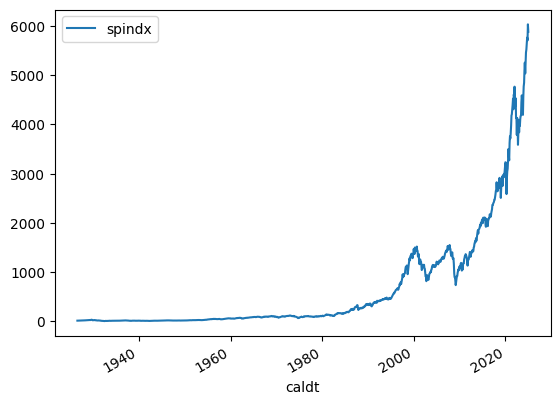

In [1129]:
df.plot.line(y="spindx", use_index=True)

Compute log returns for simpler calculations in the future

In [1130]:
# Convert simple S&P500 returns to log returns
df['sp_log_rtrn'] = np.log(1 + df['sprtrn'])

# Convert risk-free rate to log returns
df['rf_log_rtrn'] = np.log(1 + df['rf'])

# Calculate the excess log return
df['excess_log_rtrn'] = df['sp_log_rtrn'] - df['rf_log_rtrn']

# Optionally, drop the first row if you do not need the NaN value that results from the difference
df.dropna(inplace=True)

df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn
caldt,,,,,,
1926-07-31,12.88,0.045455,0.0022,0.044452,0.002198,0.042255
1926-08-31,13.10,0.017081,0.0025,0.016937,0.002497,0.014440
1926-09-30,13.40,0.022901,0.0023,0.022643,0.002297,0.020345
1926-10-30,12.98,-0.031343,0.0032,-0.031845,0.003195,-0.035040
1926-11-30,13.27,0.022342,0.0031,0.022096,0.003095,0.019001
...,...,...,...,...,...,...
2024-08-30,5648.40,0.022835,0.0048,0.022578,0.004789,0.017790
2024-09-30,5762.48,0.020197,0.0040,0.019996,0.003992,0.016004
2024-10-31,5705.45,-0.009897,0.0039,-0.009946,0.003892,-0.013839


Compute Standard deviation and expected returns with a rolling window

In [1131]:
horizon = 180 # 15 years

rolling_var = df["sp_log_rtrn"].rolling(horizon).var()
rolling_expected_rtrn = df["sp_log_rtrn"].rolling(horizon).mean()
rolling_expected_rf = df["rf_log_rtrn"].rolling(horizon).mean()

df['rolling_var'] = rolling_var
df['rolling_expected_rtrn'] = rolling_expected_rtrn
df['rolling_expected_rf'] = rolling_expected_rf  

Create a target variable by comparing if the S&P 500 of the risk-free rate will have a better performance during the next 3 months.

In [ ]:
# Define the forward-looking window (e.g., 60 months for 5 years)
window = 60

# Compute the forward cumulative log returns using a reversed rolling sum:
df['sp_cum_log_rtrn'] = df['sp_log_rtrn'][::-1].rolling(window=window, min_periods=window).sum()[::-1].shift(-1)
df['rf_cum_log_rtrn'] = df['rf_log_rtrn'][::-1].rolling(window=window, min_periods=window).sum()[::-1].shift(-1)

# Create the Target variable: 1 if the S&P 500 cumulative log return is higher than the risk-free rate, else 0
df['Target'] = (df['sp_cum_log_rtrn'] > df['rf_cum_log_rtrn']).astype(int)

# remove columns with missing values
df.dropna(inplace=True)


# Optional: inspect the resulting DataFrame
df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn,rolling_var,rolling_expected_rtrn,rolling_expected_rf,sp_cum_log_rtrn,rf_cum_log_rtrn,Target
caldt,,,,,,,,,,,,
1941-06-30,9.85,0.053476,0.0000,0.052095,0.000000,0.052095,0.009116,-0.001243,0.001014,0.718492,0.014998,1
1941-07-31,10.39,0.054822,0.0003,0.053372,0.000300,0.053072,0.009121,-0.001194,0.001003,0.626508,0.015298,1
1941-08-30,10.30,-0.008662,0.0001,-0.008700,0.000100,-0.008800,0.009120,-0.001336,0.000990,0.547304,0.015298,1
1941-09-30,10.20,-0.009709,0.0001,-0.009756,0.000100,-0.009856,0.009117,-0.001516,0.000978,0.480266,0.015498,1
1941-10-31,9.50,-0.068627,0.0000,-0.071095,0.000000,-0.071095,0.009139,-0.001734,0.000960,0.382992,0.015698,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-30,2976.74,0.017181,0.0018,0.017035,0.001798,0.015237,0.001633,0.005458,0.001056,0.657579,0.108799,1
2019-10-31,3037.56,0.020432,0.0016,0.020226,0.001599,0.018627,0.001634,0.005493,0.001059,0.660540,0.110992,1
2019-11-29,3140.98,0.034047,0.0012,0.033480,0.001199,0.032281,0.001632,0.005468,0.001057,0.630367,0.113286,1


In [1133]:
window = 246 # 20 years and 6 months
invalid_window_found = False  # flag to track if any window is missing a class

# Slide the window one step at a time
for i in range(len(df) - window + 1):
    window_values = df['Target'].iloc[i:i+window].values
    
    # Check if this window does NOT contain both 0 and 1
    if not (0 in window_values and 1 in window_values):
        invalid_window_found = True
        break  # no need to test further if one invalid window is found

print(invalid_window_found)


False


## Add Technical Indicators

Average Price (Moving Average)

In [1134]:
new_predictors = []

ma_horizons = [4, 21, 55]

for horizon in ma_horizons:
    rolling_means = df["spindx"].rolling(horizon).mean()
    ratio_column = f"ma_ratio_{horizon}"
    df[ratio_column] = df["spindx"] / rolling_means  # Use the Series directly

    new_predictors += [ratio_column]



Volatility

In [1135]:
# Compute the 10-day volatility (rolling standard deviation)
df['volatility_10'] = df['spindx'].rolling(window=10).std()

# Optionally, add this new predictor to your predictors list
new_predictors.append('volatility_10')


Moving average convergence divergence (MACD)

In [1136]:
# set parameters
n = 42 # slow EMA
m = 21 # fast EMA
p = 14  # signal line

# Calculate EMAs
df[f'slow_EMA_{n}'] = df['spindx'].ewm(span=n, adjust=False).mean()
df[f'fast_EMA_{m}'] = df['spindx'].ewm(span=m, adjust=False).mean()
df[f'signal_EMA_{p}'] = df['spindx'].ewm(span=p, adjust=False).mean()

df[f'slow_EMA_ratio{n}'] = df["spindx"] / df[f'slow_EMA_{n}']
df[f'fast_EMA_ratio{m}'] = df["spindx"] / df[f'fast_EMA_{m}']
df[f'signal_EMA_ratio{p}'] = df["spindx"] / df[f'signal_EMA_{p}']

# Compute MACD and Signal line
df['MACD'] = df[f'fast_EMA_{m}'] - df[f'slow_EMA_{n}']
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# # MACD Strategy: 1 when MACD > Signal, else -1
# df['MACD_Strategy'] = (df['MACD'] > df['Signal']).astype(int)

# # TEMA Strategy: 
# conditions = [
#     (df[f'fast_EMA_{m}'] > df[f'slow_EMA_{n}']) & (df[f'fast_EMA_{m}'] > df[f'signal_EMA_{p}']),
#     (df[f'fast_EMA_{m}'] < df[f'slow_EMA_{n}']) & (df[f'fast_EMA_{m}'] < df[f'signal_EMA_{p}'])
# ]
# choices = [1, -1]
# df['TEMA_Strategy'] = np.select(conditions, choices, default=0)



# Add new predictors to the list
new_predictors += [f'slow_EMA_ratio{n}', f'fast_EMA_ratio{m}', f'signal_EMA_ratio{p}', 'MACD']#, 'MACD_Strategy', 'TEMA_Strategy']

Plot MACD and TEMA

In [1137]:
# import matplotlib.pyplot as plt

# # Slice the DataFrame for period of interest
# df_slice = df.loc['2008':'2010']

# # Compute the transitions for MACD_Strategy:
# macd_diff = df_slice['MACD_Strategy'].diff().fillna(0)
# buy_macd = df_slice[macd_diff == 1]    # Transition from 0 to 1 (buy)
# sell_macd = df_slice[macd_diff == -1]    # Transition from 1 to 0 (sell)

# # Compute the transitions for TEMA_Strategy:
# tema_diff = df_slice['TEMA_Strategy'].diff().fillna(0)
# buy_tema = df_slice[tema_diff == 1]    # Transition from hold/sell to buy (1)
# sell_tema = df_slice[tema_diff == -1]   # Transition from buy/hold to sell (-1)

# # Create the plot with the base price series and EMAs using dynamic naming
# plt.figure(figsize=(12, 6))
# plt.plot(df_slice.index, df_slice['spindx'], label='SP Index', color='blue')
# plt.plot(df_slice.index, df_slice[f'slow_EMA_{n}'], label=f'Slow EMA ({n})', linestyle='--', color='red')
# plt.plot(df_slice.index, df_slice[f'fast_EMA_{m}'], label=f'Fast EMA ({m})', linestyle='--', color='green')
# plt.plot(df_slice.index, df_slice[f'signal_EMA_{p}'], label=f'Signal EMA ({p})', linestyle='--', color='orange')

# # Overlay MACD transition signals on the SP Index:
# plt.scatter(buy_macd.index, buy_macd['spindx'], marker='^', color='green', s=100, label='MACD Buy')
# plt.scatter(sell_macd.index, sell_macd['spindx'], marker='v', color='red', s=100, label='MACD Sell')

# # Overlay TEMA transition signals on the SP Index:
# plt.scatter(buy_tema.index, buy_tema['spindx'], marker='o', facecolors='none', edgecolors='purple', s=100, label='TEMA Buy')
# plt.scatter(sell_tema.index, sell_tema['spindx'], marker='x', color='brown', s=100, label='TEMA Sell')

# plt.title(f"SP Index and EMAs with MACD/TEMA Signal Transitions ({df_slice.index.min().year}-{df_slice.index.max().year})\n(slow_EMA_{n}, fast_EMA_{m}, signal_EMA_{p})")
# plt.xlabel("Date")
# plt.ylabel("Price")
# plt.legend()
# plt.xticks(rotation=45)
# plt.show()

Momentum

In [1138]:
momentum_periods = [12, 25, 63]  

for period in momentum_periods:
    diff_column = f"momentum_rel_diff_{period}"
    
    # Compute momentum as the difference: today's close minus the close 'period' days ago.
    df[diff_column] = df["spindx"] / (df["spindx"] - df["spindx"].shift(period))
    
    # Optionally add this to your predictors list.
    new_predictors.append(diff_column)

Rate of change (ROC):

In [1139]:
for period in momentum_periods:
    roc_column = f"ROC_rel_diff_{period}"
    
    # Compute momentum as the difference: today's close minus the close 'period' days ago.
    df[roc_column] = (df["spindx"] - df["spindx"].shift(period)) / df["spindx"].shift(period)
    
    # Optionally add this to your predictors list.
    new_predictors.append(roc_column)

Relative Strength Index (RSI)

In [1140]:
rsi_periods = [25]

for period in rsi_periods:
    rsi_col = f"RSI_{period}"
    
    # 1. Calculate Up and Down from daily log returns
    #    - 'Up' is the positive portion of the return
    #    - 'Down' is the positive portion of the negative return
    #      (we negate it so it's a positive number when returns are negative)
    up = df['sp_log_rtrn'].clip(lower=0)
    down = -df['sp_log_rtrn'].clip(upper=0)
    
    # 2. Compute rolling means of Up and Down over 'period' days
    #    (using a simple moving average for illustration)
    roll_up = up.rolling(window=period).mean()
    roll_down = down.rolling(window=period).mean()
    
    # 3. Calculate the Relative Strength (RS) = average(Up) / average(Down)
    RS = roll_up / roll_down
    
    # 4. Compute the RSI using the standard formula
    #    RSI = 100 - [ 100 / (1 + RS) ]
    df[rsi_col] = 100 - (100 / (1 + RS))
    
    # 5. Append the new column name to your predictors list
    new_predictors.append(rsi_col)


Detrended Price Oscillator (DPO):

In [1141]:
# Example array of periods for the DPO
dpo_periods = ma_horizons

for n in dpo_periods:
    # Calculate the shift for the SMA: (n//2) + 1
    shift_n = (n // 2) + 1
    
    # Compute the n-period Simple Moving Average
    sma_n = df['spindx'].rolling(window=n).mean()
    
    # Shift the SMA by shift_n periods
    sma_shifted = sma_n.shift(shift_n)
    
    # Compute DPO as the difference between today's price and the shifted SMA
    dpo_col = f"DPO_{n}"
    df[dpo_col] = df['spindx'] - sma_shifted
    
    # Optionally add the new DPO column to your list of predictors
    new_predictors.append(dpo_col)

Sharpe Ratio (SR):

In [1142]:
rolling_window = 180  # 15 years of daily data

# Compute the rolling Sharpe ratio: 
df[f'sharpe_{rolling_window}'] = df['excess_log_rtrn'].rolling(window=rolling_window).mean() / \
                                 df['sp_log_rtrn'].rolling(window=rolling_window).std()

new_predictors.append(f'sharpe_{rolling_window}')

Min/Max value over time prediction prior to period:

In [1143]:
lookback_periods = [3, 12, 60] # 3 mohth, 1 year, 5 years

for period in lookback_periods:
    # Compute the rolling maximum and shift by one to exclude today's price.
    rolling_max = df["spindx"].rolling(window=period).max().shift(1)
    max_ratio_column = f"max_ratio_{period}"
    df[max_ratio_column] = df["spindx"] / rolling_max
    
    # Compute the rolling minimum and shift by one.
    rolling_min = df["spindx"].rolling(window=period).min().shift(1)
    min_ratio_column = f"min_ratio_{period}"
    df[min_ratio_column] = df["spindx"] / rolling_min
    
    new_predictors.extend([max_ratio_column, min_ratio_column])


In [1144]:
df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn,rolling_var,rolling_expected_rtrn,rolling_expected_rf,sp_cum_log_rtrn,...,DPO_4,DPO_21,DPO_55,sharpe_180,max_ratio_3,min_ratio_3,max_ratio_12,min_ratio_12,max_ratio_60,min_ratio_60
caldt,,,,,,,,,,,,,,,,,,,,,
1941-06-30,9.85,0.053476,0.0000,0.052095,0.000000,0.052095,0.009116,-0.001243,0.001014,0.718492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1941-07-31,10.39,0.054822,0.0003,0.053372,0.000300,0.053072,0.009121,-0.001194,0.001003,0.626508,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1941-08-30,10.30,-0.008662,0.0001,-0.008700,0.000100,-0.008800,0.009120,-0.001336,0.000990,0.547304,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1941-09-30,10.20,-0.009709,0.0001,-0.009756,0.000100,-0.009856,0.009117,-0.001516,0.000978,0.480266,...,NaN,NaN,NaN,NaN,0.981713,1.035533,NaN,NaN,NaN,NaN
1941-10-31,9.50,-0.068627,0.0000,-0.071095,0.000000,-0.071095,0.009139,-0.001734,0.000960,0.382992,...,NaN,NaN,NaN,NaN,0.914341,0.931373,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-30,2976.74,0.017181,0.0018,0.017035,0.001798,0.015237,0.001633,0.005458,0.001056,0.657579,...,108.2275,362.584762,1018.609273,0.108924,0.998779,1.017181,0.998779,1.187442,0.998779,1.550361
2019-10-31,3037.56,0.020432,0.0016,0.020226,0.001599,0.018627,0.001634,0.005493,0.001059,0.660540,...,132.5525,404.522381,1061.116000,0.109696,1.019185,1.037964,1.019185,1.211704,1.019185,1.582038
2019-11-29,3140.98,0.034047,0.0012,0.033480,0.001199,0.032281,0.001632,0.005468,0.001057,0.630367,...,240.8150,501.079048,1145.552182,0.109183,1.034047,1.073304,1.034047,1.252959,1.034047,1.635902


In [1145]:
df.index = df.index.to_period('M').to_timestamp('M')
df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn,rolling_var,rolling_expected_rtrn,rolling_expected_rf,sp_cum_log_rtrn,...,DPO_4,DPO_21,DPO_55,sharpe_180,max_ratio_3,min_ratio_3,max_ratio_12,min_ratio_12,max_ratio_60,min_ratio_60
caldt,,,,,,,,,,,,,,,,,,,,,
1941-06-30,9.85,0.053476,0.0000,0.052095,0.000000,0.052095,0.009116,-0.001243,0.001014,0.718492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1941-07-31,10.39,0.054822,0.0003,0.053372,0.000300,0.053072,0.009121,-0.001194,0.001003,0.626508,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1941-08-31,10.30,-0.008662,0.0001,-0.008700,0.000100,-0.008800,0.009120,-0.001336,0.000990,0.547304,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1941-09-30,10.20,-0.009709,0.0001,-0.009756,0.000100,-0.009856,0.009117,-0.001516,0.000978,0.480266,...,NaN,NaN,NaN,NaN,0.981713,1.035533,NaN,NaN,NaN,NaN
1941-10-31,9.50,-0.068627,0.0000,-0.071095,0.000000,-0.071095,0.009139,-0.001734,0.000960,0.382992,...,NaN,NaN,NaN,NaN,0.914341,0.931373,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-30,2976.74,0.017181,0.0018,0.017035,0.001798,0.015237,0.001633,0.005458,0.001056,0.657579,...,108.2275,362.584762,1018.609273,0.108924,0.998779,1.017181,0.998779,1.187442,0.998779,1.550361
2019-10-31,3037.56,0.020432,0.0016,0.020226,0.001599,0.018627,0.001634,0.005493,0.001059,0.660540,...,132.5525,404.522381,1061.116000,0.109696,1.019185,1.037964,1.019185,1.211704,1.019185,1.582038
2019-11-30,3140.98,0.034047,0.0012,0.033480,0.001199,0.032281,0.001632,0.005468,0.001057,0.630367,...,240.8150,501.079048,1145.552182,0.109183,1.034047,1.073304,1.034047,1.252959,1.034047,1.635902


## Add Macro Vairables:

In [1146]:
import glob
import pandas as pd
from pathlib import Path

# 1. find all CSVs in the macro_variables folder (recursively)
file_paths = glob.glob("data/macro_variables/**/*.csv", recursive=True)

# 2. list of tags whose raw data is daily (we’ll take a monthly average)
daily_tags = ['DGS10']  

# 3. container for each variable’s monthly series
monthly_dfs = []

for path in file_paths:
    tag = Path(path).stem
    
    # skip the series you no longer want
    if tag == 'DCOILWTICO':
        continue
    
    # read with col 0 as the index, parse it as dates
    temp = pd.read_csv(path, index_col=0, parse_dates=True)
    temp.columns = [f"{tag}_{col}" for col in temp.columns]
    
    if tag in daily_tags:
        # — for daily series: compute the mean of each calendar month,
        #   and timestamp it at month‑end
        temp = temp.resample('M').mean()
    else:
        # — for series observed on the 1st of each month:
        #   convert the 1st‑of‑month index to the last calendar day
        temp.index = temp.index.to_period('M').to_timestamp('M')
    
    # now every temp has a month‑end index; collect it
    monthly_dfs.append(temp)

# 4. concatenate all of the monthly series side by side,
#    then drop any months where one or more series is missing
df_combined = pd.concat(monthly_dfs, axis=1).dropna()

# 5. df_combined now has a DatetimeIndex at month‑end,
#    and one column per CSV (except DCOILWTICO),
#    with daily series averaged over each month.
#
# You can inspect it or join it to your master DataFrame:
df_combined


/var/folders/wj/l2xl6tz130ndr363d0ptk9540000gn/T/ipykernel_26845/476295896.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  temp = temp.resample('M').mean()


,DGS10_DGS10,TB3MS_TB3MS,INDPRO_INDPRO,CPIAUCSL_CPIAUCSL,BAA_AAA_BAA_AAA
observation_date,,,,,
1962-01-31,4.083182,2.72,24.6496,30.040,0.66
1962-02-28,4.039444,2.73,25.0529,30.110,0.65
1962-03-31,3.930455,2.72,25.1873,30.170,0.65
1962-04-30,3.843000,2.73,25.2410,30.210,0.69
1962-05-31,3.873636,2.69,25.2141,30.240,0.72
...,...,...,...,...,...
2024-10-31,4.095455,4.51,102.2669,315.564,0.68
2024-11-30,4.355789,4.42,102.0231,316.449,0.64
2024-12-31,4.391429,4.27,103.1654,317.603,0.60


In [1147]:
df = df.join(df_combined, how='inner')

In [1148]:
df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn,rolling_var,rolling_expected_rtrn,rolling_expected_rf,sp_cum_log_rtrn,...,min_ratio_3,max_ratio_12,min_ratio_12,max_ratio_60,min_ratio_60,DGS10_DGS10,TB3MS_TB3MS,INDPRO_INDPRO,CPIAUCSL_CPIAUCSL,BAA_AAA_BAA_AAA
1962-01-31,68.84,-0.037876,0.0024,-0.038612,0.002397,-0.041009,0.001259,0.008226,0.001440,0.115746,...,1.003206,0.962124,1.114276,0.962124,1.721430,4.083182,2.72,24.6496,30.040,0.66
1962-02-28,69.96,0.016270,0.0020,0.016139,0.001998,0.014141,0.001256,0.008398,0.001449,0.229631,...,1.016270,0.977778,1.102774,0.977778,1.749437,4.039444,2.73,25.0529,30.110,0.65
1962-03-31,69.55,-0.005860,0.0020,-0.005877,0.001998,-0.007875,0.001254,0.008460,0.001459,0.215453,...,1.010314,0.972048,1.075959,0.972048,1.739185,3.930455,2.72,25.1873,30.170,0.65
1962-04-30,65.24,-0.061970,0.0022,-0.063973,0.002198,-0.066171,0.001270,0.008325,0.001469,0.259983,...,0.947705,0.911810,1.009282,0.911810,1.631408,3.843000,2.73,25.2410,30.210,0.69
1962-05-31,59.63,-0.085990,0.0024,-0.089914,0.002397,-0.092311,0.001322,0.007875,0.001481,0.365328,...,0.914010,0.833403,0.922494,0.833403,1.491123,3.873636,2.69,25.2141,30.240,0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-30,2976.74,0.017181,0.0018,0.017035,0.001798,0.015237,0.001633,0.005458,0.001056,0.657579,...,1.017181,0.998779,1.187442,0.998779,1.550361,1.699500,1.89,102.4601,256.430,0.88
2019-10-31,3037.56,0.020432,0.0016,0.020226,0.001599,0.018627,0.001634,0.005493,0.001059,0.660540,...,1.037964,1.019185,1.211704,1.019185,1.582038,1.706818,1.65,101.5878,257.155,0.91
2019-11-30,3140.98,0.034047,0.0012,0.033480,0.001199,0.032281,0.001632,0.005468,0.001057,0.630367,...,1.073304,1.034047,1.252959,1.034047,1.635902,1.812105,1.54,102.1494,257.879,0.88
2019-12-31,3230.78,0.028590,0.0014,0.028189,0.001399,0.026790,0.001631,0.005447,0.001056,0.652607,...,1.085342,1.028590,1.288781,1.028590,1.682672,1.862857,1.54,101.9421,258.630,0.87


In [1149]:

horizon = 120 # 10 years of monthly data
absolute_cols = ['INDPRO_INDPRO', 'CPIAUCSL_CPIAUCSL', 'TB3MS_TB3MS', 'DGS10_DGS10']
macro_predictors = ['BAA_AAA_BAA_AAA']

for col in absolute_cols:
    rolling_means = df[f"{col}"].rolling(horizon).mean()
    ratio_column = f"{col}_ratio"
    df[ratio_column] = df[f"{col}"] / rolling_means  # Use the Series directly
    
    macro_predictors += [ratio_column]  

new_predictors = [p for p in new_predictors if p not in macro_predictors]

# Drop the original absolute columns
df.drop(columns=absolute_cols, inplace=True)
# Add the new macro predictors to your list
new_predictors += macro_predictors


In [1150]:

df.dropna(inplace=True)

# print df column names
print(df.columns.tolist())

['spindx', 'sprtrn', 'rf', 'sp_log_rtrn', 'rf_log_rtrn', 'excess_log_rtrn', 'rolling_var', 'rolling_expected_rtrn', 'rolling_expected_rf', 'sp_cum_log_rtrn', 'rf_cum_log_rtrn', 'Target', 'ma_ratio_4', 'ma_ratio_21', 'ma_ratio_55', 'volatility_10', 'slow_EMA_42', 'fast_EMA_21', 'signal_EMA_14', 'slow_EMA_ratio42', 'fast_EMA_ratio21', 'signal_EMA_ratio14', 'MACD', 'Signal', 'momentum_rel_diff_12', 'momentum_rel_diff_25', 'momentum_rel_diff_63', 'ROC_rel_diff_12', 'ROC_rel_diff_25', 'ROC_rel_diff_63', 'RSI_25', 'DPO_4', 'DPO_21', 'DPO_55', 'sharpe_180', 'max_ratio_3', 'min_ratio_3', 'max_ratio_12', 'min_ratio_12', 'max_ratio_60', 'min_ratio_60', 'BAA_AAA_BAA_AAA', 'INDPRO_INDPRO_ratio', 'CPIAUCSL_CPIAUCSL_ratio', 'TB3MS_TB3MS_ratio', 'DGS10_DGS10_ratio']


In [1151]:
df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn,rolling_var,rolling_expected_rtrn,rolling_expected_rf,sp_cum_log_rtrn,...,min_ratio_3,max_ratio_12,min_ratio_12,max_ratio_60,min_ratio_60,BAA_AAA_BAA_AAA,INDPRO_INDPRO_ratio,CPIAUCSL_CPIAUCSL_ratio,TB3MS_TB3MS_ratio,DGS10_DGS10_ratio
1971-12-31,102.09,0.086179,0.0037,0.082666,0.003693,0.078973,0.001320,0.004349,0.003120,0.082764,...,1.086179,0.982107,1.107868,0.942050,1.403878,1.13,1.174881,1.208471,0.884689,1.134404
1972-01-31,103.94,0.018121,0.0029,0.017959,0.002896,0.015063,0.001308,0.004685,0.003122,0.051264,...,1.105862,0.999904,1.105862,0.959122,1.429318,1.04,1.198395,1.208108,0.744794,1.135097
1972-02-29,106.57,0.025303,0.0025,0.024988,0.002497,0.022491,0.001302,0.005009,0.003122,-0.018546,...,1.133844,1.025204,1.133844,0.983390,1.465484,0.96,1.205904,1.210633,0.704523,1.156797
1972-03-31,107.20,0.005912,0.0027,0.005895,0.002696,0.003198,0.001301,0.004933,0.003124,-0.065432,...,1.050054,1.005912,1.140547,0.989204,1.474147,1.00,1.209631,1.207329,0.819690,1.150545
1972-04-30,107.67,0.004384,0.0029,0.004374,0.002896,0.001479,0.001296,0.004756,0.003127,-0.085451,...,1.035886,1.004384,1.145547,0.993541,1.480611,0.94,1.216840,1.206933,0.813834,1.170060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-30,2976.74,0.017181,0.0018,0.017035,0.001798,0.015237,0.001633,0.005458,0.001056,0.657579,...,1.017181,0.998779,1.187442,0.998779,1.550361,0.88,1.038338,1.086145,3.575032,0.694393
2019-10-31,3037.56,0.020432,0.0016,0.020226,0.001599,0.018627,0.001634,0.005493,0.001059,0.660540,...,1.037964,1.019185,1.211704,1.019185,1.582038,0.91,1.028281,1.087656,3.045217,0.701397
2019-11-30,3140.98,0.034047,0.0012,0.033480,0.001199,0.032281,0.001632,0.005468,0.001057,0.630367,...,1.073304,1.034047,1.252959,1.034047,1.635902,0.88,1.032728,1.089158,2.778530,0.748742
2019-12-31,3230.78,0.028590,0.0014,0.028189,0.001399,0.026790,0.001631,0.005447,0.001056,0.652607,...,1.085342,1.028590,1.288781,1.028590,1.682672,0.87,1.029444,1.090745,2.717647,0.774317


## Initialize the model

In [1152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

# n_estimators: number of individual trees we want to train. The higher the number, the more accurate the model will be (up to a limit).
# min_samples_split: protects from overfitting (random forests tend to overfit by building deep trees). The higher the number, the less overfitting but also less accuracy.
model = RandomForestClassifier(n_estimators=500, min_samples_split=10, random_state=42)

In [1153]:
def predict(train, test, predictors, model):
    """
    Predict the target variable using the given model and predictors.
    """
    # Fit the model on the training data
    model.fit(train[predictors], train["Target"])
    
    # Make predictions on the test data
    preds = model.predict_proba(test[predictors])[:,1]  # Get the probability that the stock goes up

    # Calculate the precision score #
    pred_prob = pd.Series(preds.copy(), index=test.index, name="Pred_probability")
    
    #set a high threshold for the prediction to be true
    preds[preds >= 0.5] = 1
    preds[preds < 0.5] = 0

    preds = pd.Series(preds, index=test.index, name="Predictions")

    # Risk Aversion Coefficient Calculation #
    risk_aversion_vals = (test['rolling_expected_rtrn'] * 100 - test['rolling_expected_rf'] * 100) / ((pred_prob) * 100 * df['rolling_var'])
    risk_aversion = pd.Series(risk_aversion_vals, index=test.index, name="risk_aversion_coefficient")

    # 6. Combine everything into a single DataFrame
    combined = pd.concat([test["Target"], preds, pred_prob, risk_aversion], axis=1)

    
    # Return predictions as a Series with the same index as the test data
    return combined

In [1154]:
def backtest(data, model, predictors, start=180, step=3):
    """
    Backtest the model on the given data.
    Parameters:
        data (DataFrame): The data to backtest on.
        model: The model to use for predictions.
        predictors (list): The list of predictor columns.
        start (int): The starting index for the backtest. Every trading year has around 250 trading days.
        2500 is around 10 years. Train first model on 10 years of data.
        step (int): The step size for the backtest. Train a model every 250 days (1 trading year).
    """
    # list of dataframes where each dataframe is a prediction for a single year
    all_predictions = []
    
    # for i in range(start, data.shape[0], step):
    #     # Split the data into training and testing sets -> training set is all the years prior to the current year, gets bigger with each iteration
    #     train = data.iloc[:i].copy() # all the years prior to the current year
    #     test = data.iloc[i:i + step].copy() # the current year
        
    for i in range(0, data.shape[0] - start - step + 1, step):
        # The training set always consists of exactly 'window' entries.
        train = data.iloc[i : i + start].copy()
        # The testing set consists of the next 'step' entries.
        test = data.iloc[i + start : i + start + step].copy()
        
        # Make predictions using the predict function
        preds = predict(train, test, predictors, model)
        
        # Append predictions to the list
        all_predictions.append(preds)
    
    # Concatenate all predictions into a single DataFrame
    results = pd.concat(all_predictions)
    return results

In [1155]:
new_predictors

['ma_ratio_4',
 'ma_ratio_21',
 'ma_ratio_55',
 'volatility_10',
 'slow_EMA_ratio42',
 'fast_EMA_ratio21',
 'signal_EMA_ratio14',
 'MACD',
 'momentum_rel_diff_12',
 'momentum_rel_diff_25',
 'momentum_rel_diff_63',
 'ROC_rel_diff_12',
 'ROC_rel_diff_25',
 'ROC_rel_diff_63',
 'RSI_25',
 'DPO_4',
 'DPO_21',
 'DPO_55',
 'sharpe_180',
 'max_ratio_3',
 'min_ratio_3',
 'max_ratio_12',
 'min_ratio_12',
 'max_ratio_60',
 'min_ratio_60',
 'BAA_AAA_BAA_AAA',
 'INDPRO_INDPRO_ratio',
 'CPIAUCSL_CPIAUCSL_ratio',
 'TB3MS_TB3MS_ratio',
 'DGS10_DGS10_ratio']

In [1156]:
df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn,rolling_var,rolling_expected_rtrn,rolling_expected_rf,sp_cum_log_rtrn,...,min_ratio_3,max_ratio_12,min_ratio_12,max_ratio_60,min_ratio_60,BAA_AAA_BAA_AAA,INDPRO_INDPRO_ratio,CPIAUCSL_CPIAUCSL_ratio,TB3MS_TB3MS_ratio,DGS10_DGS10_ratio
1971-12-31,102.09,0.086179,0.0037,0.082666,0.003693,0.078973,0.001320,0.004349,0.003120,0.082764,...,1.086179,0.982107,1.107868,0.942050,1.403878,1.13,1.174881,1.208471,0.884689,1.134404
1972-01-31,103.94,0.018121,0.0029,0.017959,0.002896,0.015063,0.001308,0.004685,0.003122,0.051264,...,1.105862,0.999904,1.105862,0.959122,1.429318,1.04,1.198395,1.208108,0.744794,1.135097
1972-02-29,106.57,0.025303,0.0025,0.024988,0.002497,0.022491,0.001302,0.005009,0.003122,-0.018546,...,1.133844,1.025204,1.133844,0.983390,1.465484,0.96,1.205904,1.210633,0.704523,1.156797
1972-03-31,107.20,0.005912,0.0027,0.005895,0.002696,0.003198,0.001301,0.004933,0.003124,-0.065432,...,1.050054,1.005912,1.140547,0.989204,1.474147,1.00,1.209631,1.207329,0.819690,1.150545
1972-04-30,107.67,0.004384,0.0029,0.004374,0.002896,0.001479,0.001296,0.004756,0.003127,-0.085451,...,1.035886,1.004384,1.145547,0.993541,1.480611,0.94,1.216840,1.206933,0.813834,1.170060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-30,2976.74,0.017181,0.0018,0.017035,0.001798,0.015237,0.001633,0.005458,0.001056,0.657579,...,1.017181,0.998779,1.187442,0.998779,1.550361,0.88,1.038338,1.086145,3.575032,0.694393
2019-10-31,3037.56,0.020432,0.0016,0.020226,0.001599,0.018627,0.001634,0.005493,0.001059,0.660540,...,1.037964,1.019185,1.211704,1.019185,1.582038,0.91,1.028281,1.087656,3.045217,0.701397
2019-11-30,3140.98,0.034047,0.0012,0.033480,0.001199,0.032281,0.001632,0.005468,0.001057,0.630367,...,1.073304,1.034047,1.252959,1.034047,1.635902,0.88,1.032728,1.089158,2.778530,0.748742
2019-12-31,3230.78,0.028590,0.0014,0.028189,0.001399,0.026790,0.001631,0.005447,0.001056,0.652607,...,1.085342,1.028590,1.288781,1.028590,1.682672,0.87,1.029444,1.090745,2.717647,0.774317


Clean data and remove very low or high values

In [1157]:
# Replace infinities with NaNs first
df[new_predictors] = df[new_predictors].replace([np.inf, -np.inf], np.nan)

# Forward fill, then backward fill as a fallback:
df[new_predictors] = df[new_predictors].fillna(method='ffill')


/var/folders/wj/l2xl6tz130ndr363d0ptk9540000gn/T/ipykernel_26845/2907752904.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[new_predictors] = df[new_predictors].fillna(method='ffill')


In [1158]:
df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn,rolling_var,rolling_expected_rtrn,rolling_expected_rf,sp_cum_log_rtrn,...,min_ratio_3,max_ratio_12,min_ratio_12,max_ratio_60,min_ratio_60,BAA_AAA_BAA_AAA,INDPRO_INDPRO_ratio,CPIAUCSL_CPIAUCSL_ratio,TB3MS_TB3MS_ratio,DGS10_DGS10_ratio
1971-12-31,102.09,0.086179,0.0037,0.082666,0.003693,0.078973,0.001320,0.004349,0.003120,0.082764,...,1.086179,0.982107,1.107868,0.942050,1.403878,1.13,1.174881,1.208471,0.884689,1.134404
1972-01-31,103.94,0.018121,0.0029,0.017959,0.002896,0.015063,0.001308,0.004685,0.003122,0.051264,...,1.105862,0.999904,1.105862,0.959122,1.429318,1.04,1.198395,1.208108,0.744794,1.135097
1972-02-29,106.57,0.025303,0.0025,0.024988,0.002497,0.022491,0.001302,0.005009,0.003122,-0.018546,...,1.133844,1.025204,1.133844,0.983390,1.465484,0.96,1.205904,1.210633,0.704523,1.156797
1972-03-31,107.20,0.005912,0.0027,0.005895,0.002696,0.003198,0.001301,0.004933,0.003124,-0.065432,...,1.050054,1.005912,1.140547,0.989204,1.474147,1.00,1.209631,1.207329,0.819690,1.150545
1972-04-30,107.67,0.004384,0.0029,0.004374,0.002896,0.001479,0.001296,0.004756,0.003127,-0.085451,...,1.035886,1.004384,1.145547,0.993541,1.480611,0.94,1.216840,1.206933,0.813834,1.170060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-30,2976.74,0.017181,0.0018,0.017035,0.001798,0.015237,0.001633,0.005458,0.001056,0.657579,...,1.017181,0.998779,1.187442,0.998779,1.550361,0.88,1.038338,1.086145,3.575032,0.694393
2019-10-31,3037.56,0.020432,0.0016,0.020226,0.001599,0.018627,0.001634,0.005493,0.001059,0.660540,...,1.037964,1.019185,1.211704,1.019185,1.582038,0.91,1.028281,1.087656,3.045217,0.701397
2019-11-30,3140.98,0.034047,0.0012,0.033480,0.001199,0.032281,0.001632,0.005468,0.001057,0.630367,...,1.073304,1.034047,1.252959,1.034047,1.635902,0.88,1.032728,1.089158,2.778530,0.748742
2019-12-31,3230.78,0.028590,0.0014,0.028189,0.001399,0.026790,0.001631,0.005447,0.001056,0.652607,...,1.085342,1.028590,1.288781,1.028590,1.682672,0.87,1.029444,1.090745,2.717647,0.774317


## Make predictions and backtest the model

Select the relevant time horizon for our model training

In [1159]:
df_train_unbiased = df.iloc[-480:].copy()

In [1160]:
# predictions = backtest(df, model, new_predictors)
predictions = backtest(df_train_unbiased, model, new_predictors)

In [1161]:
predictions["Predictions"].value_counts()

Predictions
1.0    210
0.0     90
Name: count, dtype: int64

In [1162]:
precision_score(predictions["Target"], predictions["Predictions"])

0.9142857142857143

In [1163]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.666667
0    0.333333
Name: count, dtype: float64

In [1164]:
predictions

,Target,Predictions,Pred_probability,risk_aversion_coefficient
1995-02-28,1,1.0,0.997000,1.091006
1995-03-31,1,1.0,0.995091,1.557551
1995-04-30,1,1.0,0.998000,1.542276
1995-05-31,1,1.0,0.871980,1.744039
1995-06-30,1,1.0,0.871367,1.731932
...,...,...,...,...
2019-09-30,1,1.0,0.992991,2.714420
2019-10-31,1,1.0,0.993846,2.730604
2019-11-30,1,1.0,0.989528,2.730945
2019-12-31,1,1.0,0.996205,2.702208


In [1165]:
predictions["risk_aversion_coefficient"].median()

np.float64(2.4544201678554174)

In [1166]:
# Find the index of the minimum value
min_idx = predictions["risk_aversion_coefficient"].idxmax()

# Print the entire row at that index
print(predictions.loc[min_idx])


Target                         0.000000
Predictions                    0.000000
Pred_probability               0.004078
risk_aversion_coefficient    909.039971
Name: 2000-03-31 00:00:00, dtype: float64


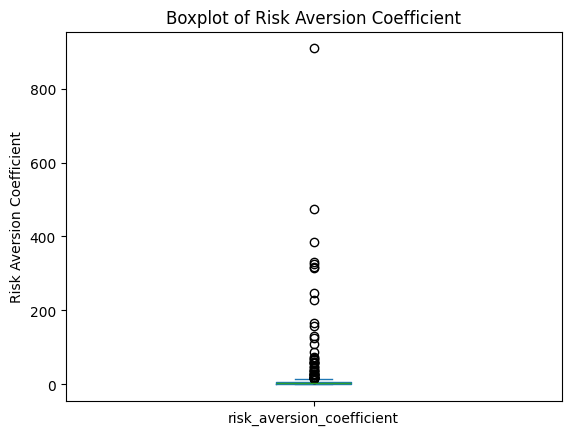

In [1167]:
import matplotlib.pyplot as plt

plt.figure()
predictions["risk_aversion_coefficient"].plot.box()
plt.ylabel("Risk Aversion Coefficient")
plt.title("Boxplot of Risk Aversion Coefficient")
plt.show()

In [1168]:
predictions["Pred_probability"].median()

np.float64(0.8429343442934774)

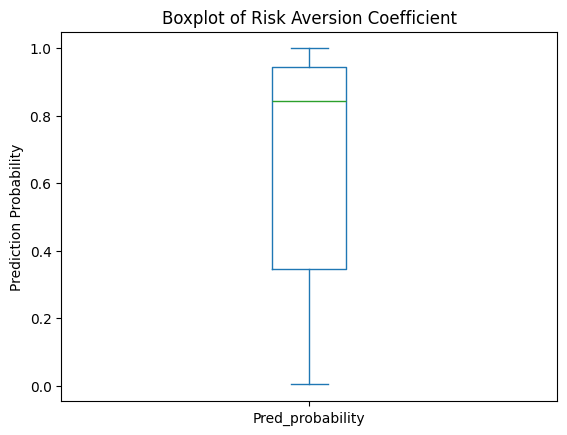

In [1169]:
plt.figure()
predictions["Pred_probability"].plot.box()
plt.ylabel("Prediction Probability")
plt.title("Boxplot of Risk Aversion Coefficient")
plt.show()

## Biased AI

In [1170]:
import pandas as pd

# 1. Select only the data before 1995-01-01
df_pre95 = df.loc[df.index < '1994-12-30']

# 2. Build the 0/1 mask for Target == 0
zero_mask = (df_pre95['Target'] == 0).astype(int)

# 3. Rolling‐sum of zeros over 180 rows (full windows only)
rolling_zero_counts = zero_mask.rolling(window=180, min_periods=180).sum()

# 4. Extract the max count and its window‐end index
max_zeros = int(rolling_zero_counts.max())
end_of_max = rolling_zero_counts.idxmax()      # the date at the end of that window

# 5. Compute the start date of the 180‑row window
end_pos   = df_pre95.index.get_indexer([end_of_max])[0]
start_pos = end_pos - 180 + 1
start_of_max = df_pre95.index[start_pos]

print(f"Max zeros (Target==0) in any 180‑row block before 1995: {max_zeros}")
print(f"Window runs from {start_of_max.date()} to {end_of_max.date()}")

# 6. If you want the slice itself:
best_slice_pre95 = df_pre95.loc[start_of_max : end_of_max]
print(best_slice_pre95)


Max zeros (Target==0) in any 180‑row block before 1995: 89
Window runs from 1971-12-31 to 1986-11-30
            spindx    sprtrn      rf  sp_log_rtrn  rf_log_rtrn  \
1971-12-31  102.09  0.086179  0.0037     0.082666     0.003693   
1972-01-31  103.94  0.018121  0.0029     0.017959     0.002896   
1972-02-29  106.57  0.025303  0.0025     0.024988     0.002497   
1972-03-31  107.20  0.005912  0.0027     0.005895     0.002696   
1972-04-30  107.67  0.004384  0.0029     0.004374     0.002896   
...            ...       ...     ...          ...          ...   
1986-07-31  236.12 -0.058683  0.0052    -0.060475     0.005187   
1986-08-31  252.93  0.071193  0.0046     0.068773     0.004589   
1986-09-30  231.32 -0.085439  0.0045    -0.089311     0.004490   
1986-10-31  243.98  0.054729  0.0046     0.053284     0.004589   
1986-11-30  249.22  0.021477  0.0039     0.021250     0.003892   

            excess_log_rtrn  rolling_var  rolling_expected_rtrn  \
1971-12-31         0.078973     0.00132

In [1171]:
df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn,rolling_var,rolling_expected_rtrn,rolling_expected_rf,sp_cum_log_rtrn,...,min_ratio_3,max_ratio_12,min_ratio_12,max_ratio_60,min_ratio_60,BAA_AAA_BAA_AAA,INDPRO_INDPRO_ratio,CPIAUCSL_CPIAUCSL_ratio,TB3MS_TB3MS_ratio,DGS10_DGS10_ratio
1971-12-31,102.09,0.086179,0.0037,0.082666,0.003693,0.078973,0.001320,0.004349,0.003120,0.082764,...,1.086179,0.982107,1.107868,0.942050,1.403878,1.13,1.174881,1.208471,0.884689,1.134404
1972-01-31,103.94,0.018121,0.0029,0.017959,0.002896,0.015063,0.001308,0.004685,0.003122,0.051264,...,1.105862,0.999904,1.105862,0.959122,1.429318,1.04,1.198395,1.208108,0.744794,1.135097
1972-02-29,106.57,0.025303,0.0025,0.024988,0.002497,0.022491,0.001302,0.005009,0.003122,-0.018546,...,1.133844,1.025204,1.133844,0.983390,1.465484,0.96,1.205904,1.210633,0.704523,1.156797
1972-03-31,107.20,0.005912,0.0027,0.005895,0.002696,0.003198,0.001301,0.004933,0.003124,-0.065432,...,1.050054,1.005912,1.140547,0.989204,1.474147,1.00,1.209631,1.207329,0.819690,1.150545
1972-04-30,107.67,0.004384,0.0029,0.004374,0.002896,0.001479,0.001296,0.004756,0.003127,-0.085451,...,1.035886,1.004384,1.145547,0.993541,1.480611,0.94,1.216840,1.206933,0.813834,1.170060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-30,2976.74,0.017181,0.0018,0.017035,0.001798,0.015237,0.001633,0.005458,0.001056,0.657579,...,1.017181,0.998779,1.187442,0.998779,1.550361,0.88,1.038338,1.086145,3.575032,0.694393
2019-10-31,3037.56,0.020432,0.0016,0.020226,0.001599,0.018627,0.001634,0.005493,0.001059,0.660540,...,1.037964,1.019185,1.211704,1.019185,1.582038,0.91,1.028281,1.087656,3.045217,0.701397
2019-11-30,3140.98,0.034047,0.0012,0.033480,0.001199,0.032281,0.001632,0.005468,0.001057,0.630367,...,1.073304,1.034047,1.252959,1.034047,1.635902,0.88,1.032728,1.089158,2.778530,0.748742
2019-12-31,3230.78,0.028590,0.0014,0.028189,0.001399,0.026790,0.001631,0.005447,0.001056,0.652607,...,1.085342,1.028590,1.288781,1.028590,1.682672,0.87,1.029444,1.090745,2.717647,0.774317


In [1172]:
preds_biased = predict(df.loc['1971-12-31':'1986-11-30'], df.iloc[-300:], new_predictors, model)

In [1176]:
preds_biased

,Target,Predictions,Pred_probability,risk_aversion_coefficient
1995-02-28,1,1.0,0.572539,1.899843
1995-03-31,1,1.0,0.571474,2.712118
1995-04-30,1,1.0,0.604310,2.547023
1995-05-31,1,1.0,0.677563,2.244467
1995-06-30,1,1.0,0.665330,2.268271
...,...,...,...,...
2019-09-30,1,1.0,0.687773,3.919014
2019-10-31,1,1.0,0.694658,3.906672
2019-11-30,1,1.0,0.722365,3.740971
2019-12-31,1,1.0,0.728796,3.693698


In [1173]:
precision_score(preds_biased["Target"], preds_biased["Predictions"])

0.6941176470588235

In [1174]:
preds_biased["risk_aversion_coefficient"].median()

np.float64(3.046877923481901)

In [1175]:
preds_biased["Pred_probability"].median()

np.float64(0.6719372913550159)